In [2]:
# Various tweaks to data processing and the model itself can impact results. 
# Visualize how the network sees the related sentiment of each word in the dataset.

#!wget --no-check-certificate \
#https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
#-O /tmp/sentiment.csv
# https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
path = tf.keras.utils.get_file('sentiment.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

C:\Users\Amir\.keras\datasets\sentiment.csv


In [5]:
dataset = pd.read_csv(path)

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
# tokenize the dataset (with tweaks!).  
# how might changing the vocab_size, embedding_dim or max_length affect ?
# how the model performs?

vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# using GlobalAveragePooling1D instead of Flatten()

model = tf.keras.Sequential([
    # embedding only needs vocab_size and emedding_dim is the number of neurons. 
    # input_length is the input layer of the X_train vector (N X max_length)
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    tf.keras.layers.GlobalAveragePooling1D(),
   
    tf.keras.layers.Dense(6, activation='relu'),
   
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 30

history = model.fit(training_padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5148 - val_loss: 0.6973 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5223 - val_loss: 0.6987 - val_accuracy: 0.4110
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5229 - val_loss: 0.6980 - val_accuracy: 0.4160
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5311 - val_loss: 0.6936 - val_accuracy: 0.4436
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5882 - val_loss: 0.6789 - val_accuracy: 0.6165
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.6842 - val_loss: 0.6797 - val_accuracy: 0.5188
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6911 - val_loss: 0.6584 - val_accuracy: 0.6040
Epoch 8/30
50/50 [==

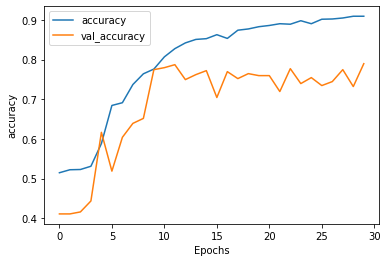

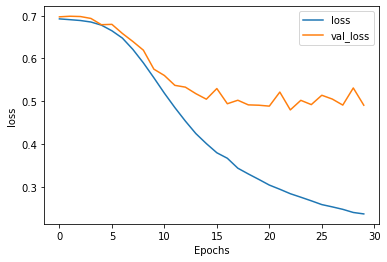

In [9]:
# visualize the training and validation accuracy with different tweaks to the hyperparameters and model.

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [10]:
df_history = pd.DataFrame(model.history.history)

<AxesSubplot:>

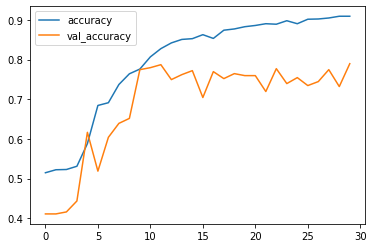

In [11]:
df_history[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

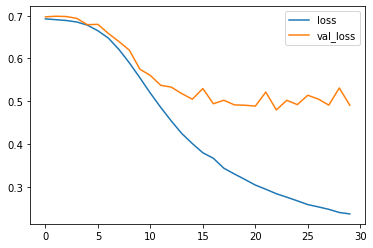

In [12]:
df_history[['loss','val_loss']].plot()

In [13]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [14]:
'''
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\nimport io\n\n# Create the reverse word index\nreverse_word_index = dict([(value, key) for (key, value) in word_index.items()])\n\n# Write out the embedding vectors and metadata\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

In [15]:
'''
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
'''

"\n# Download the files\ntry:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')\n"

In [25]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
y_prediction = np.argmax(model.predict(testing_padded), axis=-1)
print(classification_report(testing_labels_final,y_prediction))
print(confusion_matrix(testing_labels_final,y_prediction))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       235
           1       0.00      0.00      0.00       164

    accuracy                           0.59       399
   macro avg       0.29      0.50      0.37       399
weighted avg       0.35      0.59      0.44       399

[[235   0]
 [164   0]]


In [29]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != testing_labels_final)[0]
i = np.random.choice(misclassified_idx)
print(decode_review(testing_padded[i]))
print("Fake label: %s but predicted: %s" % (testing_labels_final[i], y_prediction[i]))

this place is awesome if you want <OOV> light and <OOV> during the <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Fake label: 1 but predicted: 0


In [18]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.9082759]


I hate spaghetti
[0.17110471]


Everything was cold
[0.60226107]


Everything was hot exactly as I wanted
[0.43573427]


Everything was green
[0.60226107]


the host seated us immediately
[0.59533167]


they gave us free chocolate cake
[0.8602181]


not sure about the wilted flowers on the table
[0.095774]


only works when I stand on tippy toes
[0.85016596]


does not work when I stand on my head
[0.0268235]


